In [1]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from __future__ import print_function

In [2]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [3]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [4]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [5]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

Using TensorFlow backend.


In [6]:
keras.__version__

'2.0.4'

In [7]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [8]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [10]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [11]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [12]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [13]:
def formImExt (nf, resize=(32,32), printOK=False) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            #ni = cv.normalize
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                nx = cv.resize(ni,resize)
            if (ni.shape[2]==4) :
                #r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,0],ni[:,:,3]
                r,g,b,n = cv.resize(ni[:,:,2],resize),cv.resize(ni[:,:,1],resize),cv.resize(ni[:,:,0],resize),cv.resize(ni[:,:,3],resize)
                dv,dw   = np.divide((r-n),(r+n+0.01)), np.divide((g-n),(g+n+0.01))
                nx      = np.array([r,g,b,n,dv,dw]).T; 
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [33]:
trX, trY, i, size = [],[], 0, len(nameList)
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    #nf = os.path.join(trDirTIF,nn+".tif");
    nf = os.path.join(trDirJPG,nn+".jpg");
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        #rr=np.save(os.path.join(trWork,nn+".npy"),nx);
        #trX.append(nn+".npy")
        trX.append(nx)
        trY.append(True)
    else : 
        trY.append(False)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)

print(datetime.datetime.now())
trX = np.array(trX);
trY = labelList[trY];
print(len(nameList),trX.shape,trY.shape)
#trXY=pd.DataFrame(trY); trXY['name']=trX; trXY.head()
#trXY.to_pickle(os.path.join(trWork,"listFiles.pkl"))

2017-05-18 16:09:51.030338 40479 40479
2017-05-18 16:12:30.271675 	 5000 	 train_4999
2017-05-18 16:14:32.662155 	 10000 	 train_9999
2017-05-18 16:16:21.170086 	 15000 	 train_14999
2017-05-18 16:17:57.485082 	 20000 	 train_19999
2017-05-18 16:19:17.573212 	 25000 	 train_24999
2017-05-18 16:20:26.649529 	 30000 	 train_29999
2017-05-18 16:21:34.931734 	 35000 	 train_34999
2017-05-18 16:22:38.544159 	 40000 	 train_39999
2017-05-18 16:22:44.600525
40479 (40479, 64, 64, 3) (40479, 17)


In [34]:
#np.save('../Data-Keras/train-model-2D-64x64x6-v2-XX.npy',trX)
#np.save('../Data-Keras/train-model-2D-64x64x6-v2-YY.npy',trY)
np.save('../Data-Keras/train-model-2D-64x64x3-v2-XX.npy',trX)
np.save('../Data-Keras/train-model-2D-64x64x3-v2-YY.npy',trY)

In [160]:
#del(trOX); del(trOY);

In [14]:
#trX = np.load('../Data-Keras/train-model-2D-64x64x6-v2-XX.npy')
#trY = np.load('../Data-Keras/train-model-2D-64x64x6-v2-YY.npy')
trX = np.load('../Data-Keras/train-model-2D-64x64x3-v2-XX.npy')
trY = np.load('../Data-Keras/train-model-2D-64x64x3-v2-YY.npy')
print(trX.shape,trY.shape)

(40479, 64, 64, 3) (40479, 17)


In [15]:
trX=trX/255.0
#trX=trX/65535.0
#trX[0,:,:]
#trX[:,:,:,5].max(),trX.min(),trX.shape

In [25]:
import keras.backend as K
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [17]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
#
def Kriz2012 ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [18]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
# cut version
#
#
def Kriz2012c ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(2048,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048,activation='relu'))
    model.add(Dropout(0.5))
    ##model.add(Dense(2048,activation='relu'))
    ##model.add(Dropout(0.25))
    #model.add(Dense(4096,activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [19]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
# cut version
#
#
def Kriz2012e ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Dropout(0.25))
    #model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(192,(3,3),activation='relu'))
    model.add(Dropout(0.25))
    #model.add(Convolution2D(384,(3,3),activation='relu'))
    #model.add(Dropout(0.25))
    model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.5))
    ##model.add(Dense(2048,activation='relu'))
    ##model.add(Dropout(0.25))
    #model.add(Dense(4096,activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [20]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
# cut version
#
#
def Kriz2012el ( model, iSize, rSize, pp=(96,256,384,384,256,4096,4096) ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))

    if (pp[0]>0) :
        model.add(Convolution2D(pp[0],(11,11),strides=(4,4),activation='relu'))
        model.add(Dropout(0.25))
    
    if (pp[1]>0) :
        model.add(Convolution2D(pp[1],(5,5),activation='relu'))
        model.add(Dropout(0.25))
    if (pp[2]>0) :
        model.add(Convolution2D(pp[2],(3,3),activation='relu'))
        model.add(Dropout(0.25))
    if (pp[3]>0) :
        model.add(Convolution2D(pp[3],(3,3),activation='relu'))
        model.add(Dropout(0.25))
    if (pp[4]>0) :
        model.add(Convolution2D(pp[4],(3,3),activation='relu'))
        model.add(Dropout(0.25))
        
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    
    if (pp[5]>0) :
        model.add(Dense(pp[5],activation='relu'))
        model.add(Dropout(0.5))
    if (pp[6]>0) :
        model.add(Dense(pp[6],activation='relu'))
        model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [21]:
#trX=trX/255.0
#trX[0]

In [22]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
# cut version
#
#
def Kriz2012x3x3 ( model, iSize, rSize, cv2d, dense ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(axis=3,input_shape=(i1,i2,i3)))
    
    if not (cv2d is None) :
        for cv in cv2d :
            if (cv>0) :
                model.add(Convolution2D(cv,(3,3)))
                #model.add(BatchNormalization(axis=3))
                model.add(Activation('relu'))
                model.add(Dropout(0.25))
                model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    
    if not (dense is None) :
        for de in dense :
            if (de>0) :
                model.add(Dense(pp[5],activation='relu'))
                model.add(Dropout(0.5))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [23]:
def buildModel (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    if (cv2d is None) and (dense is None) and not (params is None) : cv2d, dense = params[:-2], params[-2:]
    model = Kriz2012x3x3(model,iSize,rSize,cv2d=cv2d,dense=dense)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', #sgd, #"adam", #'rmsprop',
                  metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [63]:
#
# try model Krizevsky 2012
#
#iSize = (trX.shape[1],trX.shape[2],trX.shape[3])
iSize = (64,64,6)
#rSize = trY.shape[1]
rSize = 17
model = Sequential()
model = Kriz2012e(model,iSize,rSize)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

In [54]:
# badly don't work: fail customs metric # model=load_model('../Data-Keras/basin02-loop-all.h5') ## verify load from v1 version
#model.load_weights('../Data-Keras/train-model-020-1D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 96)        69792     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 10, 10, 256)       614656    
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 192)         442560    
_________________________________________________________________
dropout_20 (Dropout)         (None, 8, 8, 192)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 6, 6, 256)         442624    
__________

In [21]:
#mm1=np.sum([K.count_params(p) for p in set(model.trainable_weights)])
#mm2=np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])
#mm1,mm2,mm1+mm2
len(result),len(resAll)

NameError: name 'result' is not defined

In [37]:
resAll = []

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

params = [(32,64,32,0,0,256,0),(32,64,16,0,0,256,0),(32,64,32,0,0,256,0),(32,64,64,0,0,256,0),(32,64,128,0,0,256,0),(32,64,256,0,0,256,0),(32,64,512,0,0,256,0),(32,64,1024,0,0,256,0)]
params = params+[(32,64,8,0,0,16,0),(32,64,16,0,0,256,0),(32,64,32,0,0,64,0),(32,64,64,0,0,128,0),(32,64,128,0,0,256,0),(32,64,256,0,0,512,0),(32,64,512,0,0,1024,0),(32,64,1024,0,0,2048,0)]
params = params+[(32,64,8,0,0,16,128),(32,64,16,0,0,32,128),(32,64,32,0,0,64,128),(32,64,64,0,0,128,128),(32,64,128,0,0,256,128),(32,64,256,0,0,512,128),(32,64,512,0,0,1024,128),(32,64,1024,0,0,2048,128)]
params = params+[(96,256,384,384,256,4096,4096),(96,256,384,384,256,4096,2048),(96,256,384,384,256,2048,4096),(96,256,384,384,256,2048,2048),
          (96,256,384,384,0,4096,0),(96,256,384,0,256,4096,0),(96,256,0,0,256,4096,0),
          (96,256,0,0,0,4096,0),(96,0,0,0,0,4096,0),(96,256,0,0,256,4096,0)]
#         (96,256,384,197,256,4096,0),  bad unchausted memory ResourceExhaustedError: OOM when allocating tensor with shape[128,8,8,384]
#         (96,128,0,0,0,4096,0),
#
#        [(96,256,197,0,0,4096,0), (96,256,384,384,256,4096,0)]
#
#       [(96,32,0,0,0,1024,0),(96,64,0,0,0,1024,0),(96,128,0,0,0,1024,0),(96,256,0,0,0,1024,0),
#         (256,32,0,0,0,1024,0),(256,64,0,0,0,1024,0),(256,128,0,0,0,1024,0)]

params = [(96,64,0,0,0,256,0),(96,64,0,0,0,512,0),(96,64,0,0,0,1024,0),(96,64,0,0,0,2048,0),(96,64,0,0,0,8192,0)]
params = params+[(16,64,0,0,0,256,0),(32,64,0,0,0,256,0),(64,64,0,0,0,256,0),(128,64,0,0,0,256,0),(256,64,0,0,0,256,0)]

params = [(32,64,16,0,0,256,0)] 
params = [(16,32,64,256,0,512,512),(8,64,256,1024,0,512,512),(8,64,256,1024,0,0,512),(8,64,256,2048,0,0,512),(8,64,256,2048,0,512,512),
          (8,64,256,2048,0,1024,0),(8,64,256,2048,0,1024,1024)]
##params = [(8,64,256,1024,0,512,512),(8,64,256,1024,0,512,0)]
params = [(8,64,256,2048,0,2048,0)] # 0.87 0.87
params = [(8,64,256,4096,0,1024,0)] # 0.8686 0.8724
params = [(8,64,256,2048,0,1024,0),(8,64,256,2048,0,512,0),(8,64,256,4096,0,256,0)] # 0.875 0.8796

#params = [(8,64,256,4096,0,256,0)]

iSize, rSize, result = (trX.shape[1],trX.shape[2],trX.shape[3]), trY.shape[1], []
print(iSize,rSize)
epochs  = 100
verbose = 2
batch_size = 64 # 64 0.8633 0.8717 (68 secs/batch) # 32 0.8545 0.8653 (87 secs/batch) # 16 0.8483 0.8623 (137 secs/batch) # 32
for pp in params :
    model1 = buildModel(iSize,rSize,pp)
    tr1=np.sum([K.count_params(p) for p in set(model1.trainable_weights)])
    tr2=np.sum([K.count_params(p) for p in set(model1.non_trainable_weights)])
    if (tr1+tr2)>14000000 : 
        print(datetime.datetime.now(),pp,tr1+tr2,'(badly)')
        continue;
    print(datetime.datetime.now(),pp,tr1+tr2)
    hist1  = model1.fit(trX,trY,epochs=epochs, batch_size=batch_size, validation_split=0.20, 
                        callbacks=[early_stopping,reduce_lr],
                        verbose=verbose)
    
    trP = model1.predict(trX, batch_size=128)
    fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
    fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
    #print(datetime.datetime.now(),pp,hist1.history['fbeta_pred'][-1],hist1.history['val_fbeta_pred'][-1],'fbeta2s=',fbeta2score,fbeta2pred)
    print(datetime.datetime.now(),pp,'fbeta2s=',fbeta2score,fbeta2pred)
    result.append([pp,hist1])


(64, 64, 3) 17
2017-05-20 04:04:15.411722 (8, 64, 256, 2048, 0, 1024, 0) 13280317
Train on 32383 samples, validate on 8096 samples
Epoch 1/100
47s - loss: 5.1336 - acc: 0.8376 - val_loss: 4.9639 - val_acc: 0.8662
Epoch 2/100
47s - loss: 4.7658 - acc: 0.8594 - val_loss: 4.8261 - val_acc: 0.8662
Epoch 3/100
47s - loss: 4.6552 - acc: 0.8769 - val_loss: 4.7226 - val_acc: 0.8865
Epoch 4/100
47s - loss: 4.5903 - acc: 0.8715 - val_loss: 4.7085 - val_acc: 0.8466
Epoch 5/100
47s - loss: 4.5463 - acc: 0.8513 - val_loss: 4.6091 - val_acc: 0.8875
Epoch 6/100
47s - loss: 4.4922 - acc: 0.8475 - val_loss: 4.5690 - val_acc: 0.8765
Epoch 7/100
47s - loss: 4.4562 - acc: 0.8380 - val_loss: 4.5619 - val_acc: 0.8725
Epoch 8/100
47s - loss: 4.4100 - acc: 0.8397 - val_loss: 4.5438 - val_acc: 0.8668
Epoch 9/100
47s - loss: 4.3854 - acc: 0.8317 - val_loss: 4.5065 - val_acc: 0.8761
Epoch 10/100
47s - loss: 4.3423 - acc: 0.8274 - val_loss: 4.6061 - val_acc: 0.8694
Epoch 11/100
47s - loss: 4.3127 - acc: 0.8275 - 

In [28]:
print(model1.evaluate(trX,trY,verbose=2))
trP = model1.predict(trX, batch_size=512)
print(trY.shape)
print(trP.shape)
print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64))))

[4.0267106959752592, 0.66659255414769014]
(40479, 17)
(40479, 17)
fbeta_score= 0.929668474348
fbeta_pred = 0.915435888818


In [75]:
resAll = resAll+result

In [40]:
#512*64*58*58
#model1.summary()

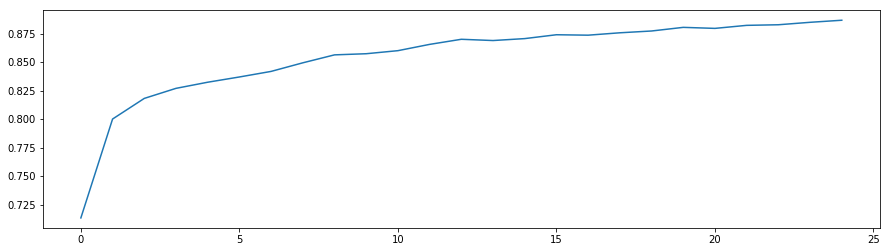

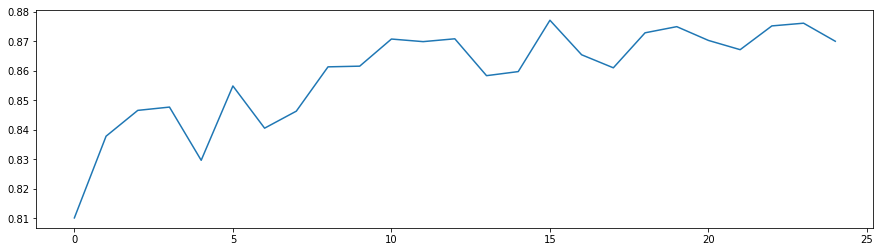

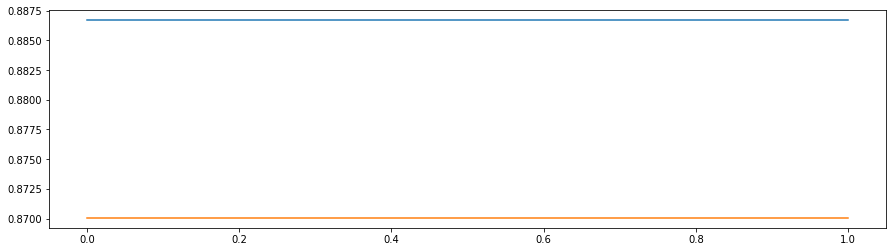

array([['0.886688977254', '0.870056623762', '8 64 256 4096 0 256 0'],
       ['0.886688977254', '0.870056623762', '8 64 256 4096 0 256 0']], 
      dtype='|S32')

In [132]:
legenda = []
temp1, temp2 = [], []
fig = plt.figure()
fig.set_size_inches(15, 4)
for ii in result :
    plt.plot(ii[1].history['fbeta_pred']);
    #plt.plot(ii[1].history['val_fbeta_pred']);
    legenda.append(' '.join([str(iii) for iii in ii[0]]))
    #temp1.append(max(ii[1].history['fbeta_pred']))
    #temp2.append(max(ii[1].history['val_fbeta_pred']))
    temp1.append(ii[1].history['fbeta_pred'][-1])
    temp2.append(ii[1].history['val_fbeta_pred'][-1])
#plt.legend(legenda)
plt.show()
fig = plt.figure()
fig.set_size_inches(15, 4)
for ii in result :
    #plt.plot(ii[1].history['fbeta_pred']);
    plt.plot(ii[1].history['val_fbeta_pred']);
    legenda.append(' '.join([str(iii) for iii in ii[0]]))
    #temp1.append(max(ii[1].history['fbeta_pred']))
    #temp2.append(max(ii[1].history['val_fbeta_pred']))
    temp1.append(ii[1].history['fbeta_pred'][-1])
    temp2.append(ii[1].history['val_fbeta_pred'][-1])
#plt.legend(legenda)
plt.show()
fig = plt.figure()
fig.set_size_inches(15, 4)
plt.plot(np.array([temp1,temp2]).T)
plt.show()

np.array([temp1,temp2,legenda]).T

In [66]:
print('time.begin :',datetime.datetime.now())
#hist_old=hist.history
early_stopping = EarlyStopping(monitor='val_loss', patience=7)
hist = model.fit(trX,trY,
         epochs=100, #10,
         batch_size=256,
         validation_split=0.20,
         callbacks=[early_stopping],
         #class_weight=rrd,
         verbose=2
         )
        #samples_per_epoch=200)
        #validation_data=validation_generator,
        #initial_epoch=start,
        #nb_val_samples=2048
         #)
print('time.end   :',datetime.datetime.now())

time.begin : 2017-05-17 05:14:18.750447
Train on 32383 samples, validate on 8096 samples
Epoch 1/100
24s - loss: 5.5929 - fbeta_pred: 0.6408 - val_loss: 5.4431 - val_fbeta_pred: 0.7480
Epoch 2/100
24s - loss: 5.2194 - fbeta_pred: 0.7692 - val_loss: 5.3803 - val_fbeta_pred: 0.7833
Epoch 3/100
24s - loss: 5.0939 - fbeta_pred: 0.7881 - val_loss: 5.2377 - val_fbeta_pred: 0.7989
Epoch 4/100
24s - loss: 5.0156 - fbeta_pred: 0.7980 - val_loss: 5.1082 - val_fbeta_pred: 0.7989
Epoch 5/100
24s - loss: 4.9826 - fbeta_pred: 0.7998 - val_loss: 5.0409 - val_fbeta_pred: 0.8102
Epoch 6/100
24s - loss: 4.8825 - fbeta_pred: 0.8118 - val_loss: 4.9103 - val_fbeta_pred: 0.8306
Epoch 7/100
24s - loss: 4.8288 - fbeta_pred: 0.8173 - val_loss: 4.8410 - val_fbeta_pred: 0.8255
Epoch 8/100
24s - loss: 4.8034 - fbeta_pred: 0.8163 - val_loss: 4.8116 - val_fbeta_pred: 0.8364
Epoch 9/100
24s - loss: 4.7672 - fbeta_pred: 0.8225 - val_loss: 4.8060 - val_fbeta_pred: 0.8298
Epoch 10/100
24s - loss: 4.7304 - fbeta_pred: 0

In [30]:
model = model1

In [79]:
save_model(model,'../Data-Keras/train-model-2D-2-v2-all.h5')
model.save_weights('../Data-Keras/train-model-2D-2-v2-weights.h5')  # save weights after training

In [51]:
print(model.evaluate(trX,trY,verbose=2))
trP = model.predict(trX, batch_size=128)
print(trY.shape)
print(trP.shape)
print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64))))

[4.6118634846927931, 0.86373419225261561]
(40479, 17)
(40479, 17)
fbeta_score= 0.869308013872
fbeta_pred = 0.863331963306


In [45]:
print(model.evaluate(trX,trY,verbose=2))
trP = model.predict(trX, batch_size=512)
print(trY.shape)
print(trP.shape)
print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64))))

[4.5661148273054595, 0.85369781466228234]
(40479, 17)
(40479, 17)
fbeta_score= 0.868993583256
fbeta_pred = 0.853273634755


In [286]:
#hist_old=hist.history

In [31]:
rr, rrx = [], []; trP = model.predict(trX, batch_size=128)
for i in range(trP.shape[1]) :
    xx = [];
    trYY = trY[:,i].astype(np.float64)
    trPY = trP[:,i]
    for ii in range(100) :
        trPP = (trPY>0.01*ii).astype(np.float64)
        #x = fbeta_score(trY[:,0], np.array(trP[:,0] > 0.1*ii), beta=2, average='samples')
        x = K.get_value(fbeta_pred(trYY,trPP))
        xx.append(x)
    rrr = np.array(xx).argmax();
    rr.append(rrr)
    rrx.append(xx[rrr])
    print(datetime.datetime.now(),i,'-->',rrr,xx[rrr],xx[(rrr-1):(rrr+2)])
    #print(xx);
    #plt.plot(np.array(xx)); plt.show()
trM = np.array(rr)/100.0;

2017-05-20 05:22:01.009723 0 --> 70 0.758419290079 [0.75741733368803943, 0.75841929007857778, 0.75785138394714635]
2017-05-20 05:22:23.972821 1 --> 78 0.982638483662 [0.98262473453994426, 0.98263848366246676, 0.98259679666709321]
2017-05-20 05:22:52.632376 2 --> 58 0.847226297632 [0.8469111862002846, 0.84722629763157453, 0.84682213028656683]
2017-05-20 05:23:27.033547 3 --> 78 0.97604678248 [0.97585536488705449, 0.97604678247993626, 0.97586138532621902]
2017-05-20 05:24:07.288213 4 --> 39 0.78729476795 [0.78664609854346335, 0.78729476795032916, 0.78707371492899492]
2017-05-20 05:24:52.980975 5 --> 42 0.789568102568 [0.78871126051941221, 0.78956810256787635, 0.78669767415698355]
2017-05-20 05:25:44.022237 6 --> 47 0.830831644043 [0.8305167161398419, 0.83083164404299403, 0.83015444819651052]
2017-05-20 05:26:40.712293 7 --> 45 0.738016164169 [0.73686966073098015, 0.73801616416924898, 0.73773213859960107]
2017-05-20 05:27:43.679293 8 --> 26 0.676190170231 [0.6690774577597115, 0.6761901702

In [32]:
save_model(model,  '../Data-Keras/train-model-2D-2-v2-loop-all.h5')
model.save_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5')  # save weights after training

In [26]:
model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [27]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [34]:
#nameAsk = os.listdir(teDirI); print(len(nameAsk))
nameAsk = os.listdir(teDirJPG); print(len(nameAsk))
trOX, trOY, i, ii, size = [], [], 0, 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    #nf = os.path.join(teDirTIF,nn);
    nf = os.path.join(teDirJPG,nn);
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%10000==0) and (i>1) :
        if (ii==0) :
            trOX = np.array(trOX); trOX = trOX / 255.0
            trP = model.predict(trOX, batch_size=512); 
        else :
            trOX = np.array(trOX);  trOX = trOX / 255.0
            trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
        trOX,ii = [],ii+1;
    if (i%5000==0) : print(datetime.datetime.now(),"\t",ii,'\t',i,"\t",nn,'\t',(trP.shape if ii>0 else ""))

if (len(trOX)>0) :
    if (ii==0) :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = model.predict(trOX, batch_size=512); 
    else :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
    trOX,ii = [],ii+1;
    
print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-05-20 05:46:19.287685 61191 61191
2017-05-20 05:46:38.218814 	 0 	 5000 	 test_14523.jpg 	 
2017-05-20 05:46:51.023731 	 1 	 10000 	 test_19029.jpg 	 (10000, 17)
2017-05-20 05:46:58.884016 	 1 	 15000 	 test_23524.jpg 	 (10000, 17)
2017-05-20 05:47:09.507695 	 2 	 20000 	 test_28015.jpg 	 (20000, 17)
2017-05-20 05:47:16.475888 	 2 	 25000 	 test_32520.jpg 	 (20000, 17)
2017-05-20 05:47:26.837760 	 3 	 30000 	 test_37026.jpg 	 (30000, 17)
2017-05-20 05:47:33.858034 	 3 	 35000 	 test_4908.jpg 	 (30000, 17)
2017-05-20 05:47:44.019579 	 4 	 40000 	 test_9402.jpg 	 (40000, 17)
2017-05-20 05:47:51.298769 	 4 	 45000 	 file_13913.jpg 	 (40000, 17)
2017-05-20 05:48:01.555641 	 5 	 50000 	 file_18419.jpg 	 (50000, 17)
2017-05-20 05:48:24.538867 	 5 	 55000 	 file_4564.jpg 	 (50000, 17)
2017-05-20 05:48:40.785101 	 6 	 60000 	 file_892.jpg 	 (60000, 17)
2017-05-20 05:48:43.863555


In [36]:
#trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trP.shape,trOY.shape)

61191 (61191, 17) (61191,)


In [ ]:
# Saving & Loading

In [26]:
np.save('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy',trOX)
np.save('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy',trOY)

In [27]:
trOX = np.load('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy')
trOY = np.load('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy')
print(trOX.shape,trOY.shape)

(61191, 32, 32, 6) (61191,)


In [37]:
rrx
rrd=dict()
for i in range(len(rrx)) :
    rrd[i]=rrx[i]
rrd

{0: 0.75841929007857778,
 1: 0.98263848366246676,
 2: 0.84722629763157453,
 3: 0.97604678247993626,
 4: 0.78729476795032916,
 5: 0.78956810256787635,
 6: 0.83083164404299403,
 7: 0.73801616416924898,
 8: 0.6761901702314258,
 9: 0.86068787363532673,
 10: 0.96403428373772715,
 11: 0.90053737661152566,
 12: 0.6528441526860862,
 13: 0.86359942524081812,
 14: 0.37037005520335736,
 15: 0.68382329252278806,
 16: 0.58917169677281178}

In [258]:
#Forming result

In [30]:
#trP = model.predict(trOX, batch_size=512); 
trP.shape, trP[-1]

((61191, 17), array([  6.56801313e-02,   7.46541142e-01,   2.32726157e-01,
          9.55386758e-01,   1.95543230e-01,   9.11955476e-01,
          8.89197826e-01,   2.53069662e-02,   1.54045611e-05,
          7.43342913e-04,   6.54759035e-02,   6.17289741e-04,
          8.51887614e-02,   2.95602629e-04,   2.64362683e-07,
          1.03749386e-04,   2.92145728e-07], dtype=float32))

In [38]:
trM=np.array([0.0]*len(labels)); print(trM.shape)
wr = [labels.index(i) for i in weather_labels];
tt=trM; trM[:]=0.5
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

(17,)
[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [39]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trPP = [weather_labels[trP[i,wr].argmax()]] + [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])];
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  1.63650557e-01   3.91220033e-01   1.36160061e-01   9.47374701e-01
   9.09343541e-01   1.55211976e-02   3.13203782e-02   1.42206885e-02
   8.06170846e-08   9.10553038e-01   7.85041321e-03   4.12757437e-08
   6.71853591e-03   1.33155788e-06   7.46736941e-06   9.65268737e-06
   7.95199711e-08]


In [40]:
print(labels)
#print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18


In [ ]:
#Garbages

In [ ]:
#import pickle
#type(resAll[0][1].epoch)
#resAll[0][1].__dict__
print(type(resAll))

#resPic = [[aa[0],aa[1]['fbeta_pred'],aa[1].history['loss'],aa[1].history['val_fbeta_pred'],aa[1]['val_loss']] for aa in resAll]
resPic = [[aa[0],aa[1].history['fbeta_pred'],aa[1].history['loss'],aa[1].history['val_fbeta_pred'],aa[1].history['val_loss']] for aa in resAll]; 
len(resPic); #resPic[0]

xfile=open('../Data-Keras/resAll.pcl','wb')
pickle.dump(resPic,xfile); xfile.close()
xx=[]
xfile=open('../Data-Keras/resAll.pcl','rb')
xx=pickle.load(xfile);  xfile.close()
len(resAll),len(xx) #, xx[0]